3. Zadatak: IV, WoE izračuni:
- Izračunati IV, WoE za svaku varijablu i prikazati u Jupyter Notebooku
- Izdvojiti varijable sa najjačim IV-om i prikazati grafički WoE graf za sve najjače varijable
- Grupirati razrede po kriteriju WoE za najjače varijable
- Objasniti što ste spoznali temeljem ove analize (profili, uzroci, uzročno posljedične veze)
- Predložite kako biste riješili problem vezano uz vaš skup podataka temeljem  IV, WoE analize (što bi trebalo mijenjati, raditi drugačije, gdje je problem uzrok problema, koji su rizični profili … )
- Sve mora biti vidljivo u Jupyter Notebooku, kod i rezultati, kao i komentari
- Objasniti / komentirati nalaze

**Cilj:** Kvantificirati koliko svaka kategorija varijable doprinosi vjerojatnosti da će učenik imati ocjenu **G1 <= 10** (pad).

#### Metodologija Weight of Evidence (WoE) i Information Value (IV)

**WoE (Weight of Evidence)** mjeri povezanost pojedine kategorije unutar jedne varijable s ciljnom varijablom (WoE možemo koristiti samo na kategoričkim varijablama, za kontinuirane potrenbo ih je diskretizirati):
$$WoE = \ln\frac{\%Dobri}{\%Loši}$$

**IV (Information Value)** mjeri ukupnu prediktivnu snagu varijable (služi za odabir atributa koje ćemo uključiti u izradu prediktivnog modela i njihovo rangiranje po važnosti):
$$IV = \sum [(\%Dobri - \%Loši) \times WoE]$$

#### Interpretacija IV vrijednosti:
| IV vrijednost | Snaga prediktora |
|---|---|
| < 0.02 | Vrlo slab utjecaj |
| 0.02 – 0.1 | Slab utjecaj |
| 0.1 – 1.0 | Jak utjecaj |
| > 1.0 | Vrlo jak utjecaj |

**Doprinos analizi:**
- Omogućuje rangiranje varijabli po važnosti za predikciju
- Identificira kategorije koje nose najviše informacija o riziku
- Pomaže u odabiru varijabli za prediktivne modele


---

## 1. Učitavanje podataka i priprema ciljne varijable

**Što radimo:** Učitavamo dataset i kreiramo binarnu ciljnu varijablu gdje:
- `target_G1 = 1` → učenik je pao (G1 <= 10) - "Loši"
- `target_G1 = 0` → učenik je položio (G1 > 10) - "Dobri"

**Doprinos analizi:** WoE/IV metodologija zahtijeva binarnu ciljnu varijablu. Prag 10 odabran je kao granica prolaza/pada.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

df = pd.read_csv('../dataset/student-por.csv', sep=';')

print(f"Dimenzije dataseta: {df.shape}")
print(f"Broj učenika: {df.shape[0]}")
print(f"Broj atributa: {df.shape[1]}")

# Kreiranje ciljne varijable: target_G1 = 1 ako je G1 <= 10 (pad/"Loši"), inače 0 ("Dobri")
df['target_G1'] = (df['G1'] <= 10).astype(int)

print("DISTRIBUCIJA CILJNE VARIJABLE")
print("="*60)
print(f"\nBroj učenika s prolazom (G1 > 10):  {(df['target_G1'] == 0).sum()}")
print(f"Broj učenika s padom (G1 <= 10):    {(df['target_G1'] == 1).sum()}")
print(f"\nPostotak učenika s padom: {(df['target_G1'].mean() * 100):.1f}%")


Dimenzije dataseta: (649, 33)
Broj učenika: 649
Broj atributa: 33
DISTRIBUCIJA CILJNE VARIJABLE

Broj učenika s prolazom (G1 > 10):  397
Broj učenika s padom (G1 <= 10):    252

Postotak učenika s padom: 38.8%


---

## 2. Izračun WoE i IV za svaku varijablu

**Što radimo:** Za svaku varijablu (kategoričku ili diskretiziranu kontinuiranu) računamo:
1. **Krostabulaciju** između prediktora i ciljne varijable (kako su međusobno povezani - kako su kategorije koje smo napravili povezane sa "Dobri" ili "Loši")
2. **Postotni udio** "loših" (G1 <= 10) i "dobrih" (G1 > 10) ishoda unutar svake kategorije
3. **WoE** za svaku kategoriju: ln(%Dobri / %Loši)
4. **IV** za cijelu varijablu: Σ[(%Dobri - %Loši) × WoE]

**Doprinos analizi:**
- Identificira koje kategorije unutar svake varijable najviše doprinose riziku pada
- Kvantificira prediktivnu snagu svake varijable
- Omogućuje rangiranje varijabli za odabir u prediktivni model


In [16]:
def calculate_woe_iv(df, feature, target, bins=5):
    """
    Izračunava WoE i IV za pojedinu varijablu.
    
    Parametri:
    -----------
    df : DataFrame - podaci
    feature : str - naziv varijable za analizu
    target : str - naziv ciljne varijable (binarna: 0=Dobri, 1=Loši)
    bins : int - broj binova za diskretizaciju kontinuiranih varijabli (pretvaranje kontinuiranih numeričkih vrijednosti u kategorije)
    
    Povratna vrijednost:
    -----------
    tuple: (woe_df, iv_value)
        - woe_df: DataFrame s WoE i IV po kategorijama
        - iv_value: ukupna IV vrijednost za varijablu
    """
    # Ako je numerička varijabla, diskretiziraj je
    if np.issubdtype(df[feature].dtype, np.number):
        try:
            temp_feature = pd.qcut(df[feature], bins, duplicates='drop') # qcut dijeli na jednake kategorije
        except ValueError:
            # Ako qcut ne uspije, koristi cut
            temp_feature = pd.cut(df[feature], bins, duplicates='drop')
    else:
        temp_feature = df[feature]
    
    # Kreiranje krostabulacije
    crosstab = pd.crosstab(temp_feature, df[target])
    
    # Provjeri da imamo obje klase (Dobri i Loši)
    if 0 not in crosstab.columns:
        crosstab[0] = 0
    if 1 not in crosstab.columns:
        crosstab[1] = 0
    
    # Preimenovanje stupaca za jasnoću
    crosstab.columns = ['Dobri', 'Loši']
    
    # Izračunaj distribucije (postotke)
    total_dobri = crosstab['Dobri'].sum()
    total_losi = crosstab['Loši'].sum()
    
    # Dodavanje malog epsilona za izbjegavanje dijeljenja s nulom
    epsilon = 0.0001
    
    crosstab['%_Dobri'] = crosstab['Dobri'] / total_dobri
    crosstab['%_Loši'] = crosstab['Loši'] / total_losi
    
    # Zamijeni nule s epsilon za izbjegavanje log(0)
    crosstab['%_Dobri'] = crosstab['%_Dobri'].replace(0, epsilon)
    crosstab['%_Loši'] = crosstab['%_Loši'].replace(0, epsilon)
    
    # Izračunavanje WoE: ln(%Dobri / %Loši)
    crosstab['WoE'] = np.log(crosstab['%_Dobri'] / crosstab['%_Loši'])
    
    # Izračunavanje IV po kategorijama
    crosstab['IV'] = (crosstab['%_Dobri'] - crosstab['%_Loši']) * crosstab['WoE']
    
    iv_value = crosstab['IV'].sum()
    
    return crosstab, iv_value


def get_iv_interpretation(iv):
    """Vraća tekstualnu interpretaciju IV vrijednosti."""
    if iv > 1.0:
        return "Vrlo jak utjecaj"
    elif iv >= 0.1:
        return "Jak utjecaj"
    elif iv >= 0.02:
        return "Slab utjecaj"
    else:
        return "Vrlo slab utjecaj"


# RUČNI BINNING ZA 'failures' VARIJABLU
# Varijabla 'failures' ima većinu vrijednosti 0, pa automatski qcut ne radi dobro
# Zato ju ručno binariziramo: 0 = "Nema_neuspjeha", >=1 = "Ima_neuspjeha"
df['failures_binned'] = df['failures'].apply(lambda x: 'Nema_neuspjeha' if x == 0 else 'Ima_neuspjeha')
print("Kreirana binarna varijabla 'failures_binned' za ispravnu WoE/IV analizu")
print(f"Distribucija: {df['failures_binned'].value_counts().to_dict()}\n")

# (isključujemo G1, G2, G3 jer su ciljne/buduće ocjene)
# Također isključujemo originalni 'failures' i koristimo 'failures_binned' umjesto njega
exclude_cols = ['G1', 'G2', 'G3', 'target_G1', 'failures']
all_features = [col for col in df.columns if col not in exclude_cols]

print(f"Broj varijabli za WoE/IV analizu: {len(all_features)}")
print(f"\nVarijable: {all_features}")


Kreirana binarna varijabla 'failures_binned' za ispravnu WoE/IV analizu
Distribucija: {'Nema_neuspjeha': 549, 'Ima_neuspjeha': 100}

Broj varijabli za WoE/IV analizu: 30

Varijable: ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'failures_binned']


In [17]:
iv_results = []
woe_tables = {}

print("IZRAČUN WoE I IV ZA SVE VARIJABLE...")
print("="*80)

for feature in all_features:
    try:
        woe_df, iv_value = calculate_woe_iv(df, feature, 'target_G1', bins=5)
        woe_tables[feature] = woe_df
        
        iv_results.append({
            'Varijabla': feature,
            'IV': round(iv_value, 4),
            'Prediktivnost': get_iv_interpretation(iv_value)
        })
    except Exception as e:
        print(f"Greška za {feature}: {e}")

# Kreiraj DataFrame s rezultatima, sortiraj po IV silazno
iv_df = pd.DataFrame(iv_results)
iv_df = iv_df.sort_values('IV', ascending=False).reset_index(drop=True)

print("TABLICA IV VRIJEDNOSTI ZA SVE VARIJABLE (sortirano silazno)")
print("\nVarijable s IV > 0.1 smatraju se značajnima (jak utjecaj) za predikciju pada.\n")

display(iv_df)

iv_df.to_csv('WoE_IV_rezultati.csv', index=False, sep=';')
print("\n Rezultati spremljeni u 'WoE_IV_rezultati.csv'")


IZRAČUN WoE I IV ZA SVE VARIJABLE...
TABLICA IV VRIJEDNOSTI ZA SVE VARIJABLE (sortirano silazno)

Varijable s IV > 0.1 smatraju se značajnima (jak utjecaj) za predikciju pada.



,Varijabla,IV,Prediktivnost
0,failures_binned,0.8580,Jak utjecaj
1,higher,0.5162,Jak utjecaj
2,school,0.4156,Jak utjecaj
3,Medu,0.2643,Jak utjecaj
4,Dalc,0.1940,Jak utjecaj
5,age,0.1902,Jak utjecaj
6,Mjob,0.1797,Jak utjecaj
7,reason,0.1543,Jak utjecaj
8,Fedu,0.1499,Jak utjecaj
9,address,0.1177,Jak utjecaj



 Rezultati spremljeni u 'WoE_IV_rezultati.csv'


---

## 3. Izdvajanje najjačih varijabli i grafički prikaz

**Što radimo:** 
1. Rangiramo varijable po IV vrijednosti i izdvajamo top 5 najjačih
2. Za svaku od tih varijabli crtamo stupčasti dijagram WoE vrijednosti

**Interpretacija WoE grafikona:**
- **Negativniji WoE** (ispod nule) → kategorije koje su sklonije padu na G1 (znači da je u toj kategoriji više "loših" nego "dobrih" učenika)
- **Pozitivniji WoE** (iznad nule) → kategorije koje su sklonije prolazu (znači da je u toj kategoriji više "dobrih" nego "loših" učenika)
- **Veća apsolutna vrijednost** → jači utjecaj kategorije na ishod

**Doprinos analizi:**
- Vizualno identificira trendove rizika kod najbitnijih faktora
- Omogućuje razumijevanje SMJERA utjecaja svake kategorije
- Pomaže u identificiranju rizičnih profila učenika


TOP 5 NAJJAČIH VARIJABLI PO PREDIKTIVNOJ SNAZI (IV)


,Varijabla,IV,Prediktivnost
0,failures_binned,0.8580,Jak utjecaj
1,higher,0.5162,Jak utjecaj
2,school,0.4156,Jak utjecaj
3,Medu,0.2643,Jak utjecaj
4,Dalc,0.1940,Jak utjecaj


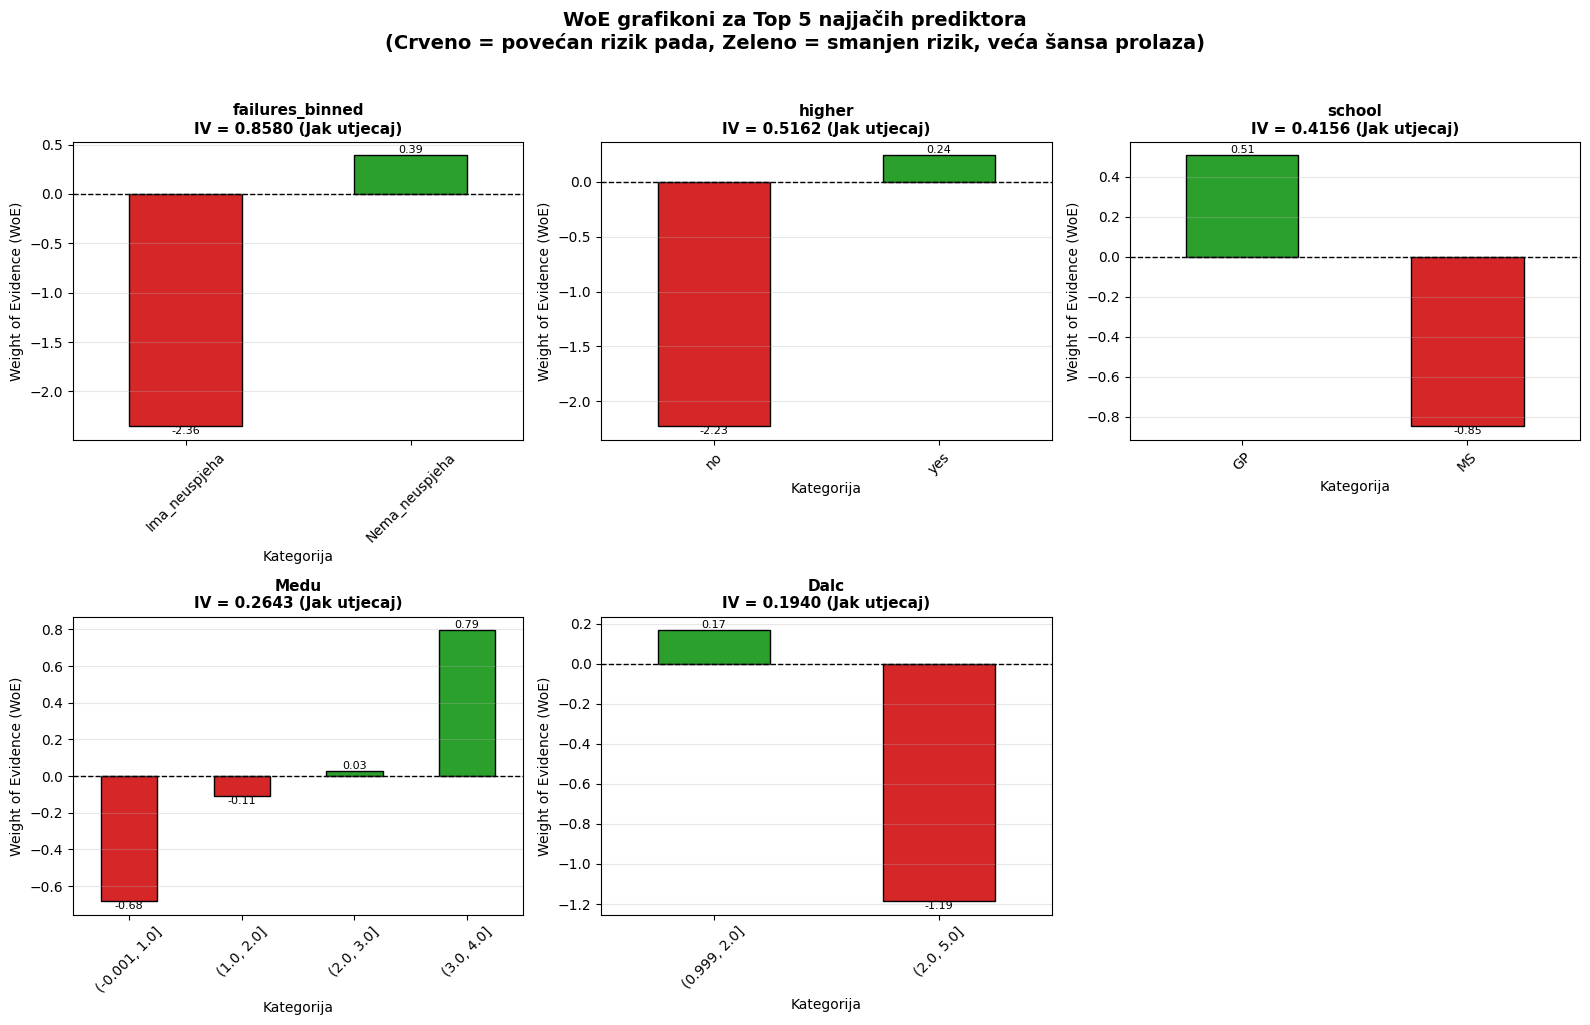


 Grafikon spremljen kao 'woe_top5_grafikoni.png'


In [18]:
# Izdvajanje top 5 varijabli po IV
top_n = 5
top_features = iv_df.head(top_n)

print(f"TOP {top_n} NAJJAČIH VARIJABLI PO PREDIKTIVNOJ SNAZI (IV)")
print("="*80)
display(top_features)

# Kreiranje grafikona WoE za top varijable
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, row in top_features.iterrows():
    feature = row['Varijabla']
    iv_value = row['IV']
    
    # Dohvati WoE tablicu
    woe_df = woe_tables[feature]
    
    # Crtanje stupčastog dijagrama
    ax = axes[idx]
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in woe_df['WoE'].values]
    woe_df['WoE'].plot(kind='bar', ax=ax, color=colors, edgecolor='black')
    
    ax.set_title(f'{feature}\nIV = {iv_value:.4f} ({row["Prediktivnost"]})', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Kategorija')
    ax.set_ylabel('Weight of Evidence (WoE)')
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax.grid(axis='y', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    # Dodavanje vrijednosti iznad/ispod stupaca
    for i, v in enumerate(woe_df['WoE'].values):
        va = 'bottom' if v >= 0 else 'top'
        ax.text(i, v, f'{v:.2f}', ha='center', va=va, fontsize=8)

# Sakrij prazan subplot
axes[5].axis('off')

plt.suptitle('WoE grafikoni za Top 5 najjačih prediktora\n(Crveno = povećan rizik pada, Zeleno = smanjen rizik, veća šansa prolaza)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n Grafikon spremljen kao 'woe_top5_grafikoni.png'")


Primjer čitanja: 
| Varijabla = Vrijednost | Objašnjenje |
| :--- | :--- |
| **Broj dobrih = 297** | U ovom binu nalazi se 297 dobrih slučajeva (npr. studenti koji prolaze, imaju G > 10). |
| **Broj loših = 220** | U ovom binu nalazi se 220 loših slučajeva (studenti koji padaju, imaju G ≤ 10). |
| **Postotak dobrih = 0.748 (74.8%)** | 74.8% svih dobrih studenata nalazi se u ovom binu. |
| **Postotak loših = 0.873 (87.3%)** | 87.3% svih loših studenata nalazi se u ovom binu. |
| **WoE = -0.154** | U ovom binu ima relativno više loših nego dobrih; bin ima negativan utjecaj (rizičan bin). |
| **IV = 0.019** | Ovaj bin slabo doprinosi razdvajanju dobrih i loših. |

In [19]:
print("DETALJNE WoE TABLICE ZA TOP 5 VARIJABLI")
print("="*80)

for idx, row in top_features.iterrows():
    feature = row['Varijabla']
    iv_value = row['IV']
    
    print(f"\n{'─'*60}")
    print(f" {feature.upper()} (IV = {iv_value:.4f})")
    print(f"{'─'*60}")
    
    woe_df = woe_tables[feature]
    display(woe_df.round(4))
    
    # Interpretacija
    min_woe_cat = woe_df['WoE'].idxmin()
    max_woe_cat = woe_df['WoE'].idxmax()
    
    print(f"\n Najviši rizik pada: {min_woe_cat} (WoE = {woe_df.loc[min_woe_cat, 'WoE']:.3f})")
    print(f" Najniži rizik pada: {max_woe_cat} (WoE = {woe_df.loc[max_woe_cat, 'WoE']:.3f})")


DETALJNE WoE TABLICE ZA TOP 5 VARIJABLI

────────────────────────────────────────────────────────────
 FAILURES_BINNED (IV = 0.8580)
────────────────────────────────────────────────────────────


,Dobri,Loši,%_Dobri,%_Loši,WoE,IV
failures_binned,,,,,,
Ima_neuspjeha,13,87,0.0327,0.3452,-2.3555,0.7361
Nema_neuspjeha,384,165,0.9673,0.6548,0.3902,0.1219



 Najviši rizik pada: Ima_neuspjeha (WoE = -2.355)
 Najniži rizik pada: Nema_neuspjeha (WoE = 0.390)

────────────────────────────────────────────────────────────
 HIGHER (IV = 0.5162)
────────────────────────────────────────────────────────────


,Dobri,Loši,%_Dobri,%_Loši,WoE,IV
higher,,,,,,
no,10,59,0.0252,0.2341,-2.2295,0.4658
yes,387,193,0.9748,0.7659,0.2412,0.0504



 Najviši rizik pada: no (WoE = -2.229)
 Najniži rizik pada: yes (WoE = 0.241)

────────────────────────────────────────────────────────────
 SCHOOL (IV = 0.4156)
────────────────────────────────────────────────────────────


,Dobri,Loši,%_Dobri,%_Loši,WoE,IV
school,,,,,,
GP,306,117,0.7708,0.4643,0.5069,0.1554
MS,91,135,0.2292,0.5357,-0.8489,0.2602



 Najviši rizik pada: MS (WoE = -0.849)
 Najniži rizik pada: GP (WoE = 0.507)

────────────────────────────────────────────────────────────
 MEDU (IV = 0.2643)
────────────────────────────────────────────────────────────


,Dobri,Loši,%_Dobri,%_Loši,WoE,IV
Medu,,,,,,
"(-0.001, 1.0]",66,83,0.1662,0.3294,-0.6837,0.1115
"(1.0, 2.0]",109,77,0.2746,0.3056,-0.1070,0.0033
"(2.0, 3.0]",86,53,0.2166,0.2103,0.0295,0.0002
"(3.0, 4.0]",136,39,0.3426,0.1548,0.7946,0.1492



 Najviši rizik pada: (-0.001, 1.0] (WoE = -0.684)
 Najniži rizik pada: (3.0, 4.0] (WoE = 0.795)

────────────────────────────────────────────────────────────
 DALC (IV = 0.1940)
────────────────────────────────────────────────────────────


,Dobri,Loši,%_Dobri,%_Loši,WoE,IV
Dalc,,,,,,
"(0.999, 2.0]",372,200,0.937,0.7937,0.1661,0.0238
"(2.0, 5.0]",25,52,0.063,0.2063,-1.1869,0.1702



 Najviši rizik pada: (2.0, 5.0] (WoE = -1.187)
 Najniži rizik pada: (0.999, 2.0] (WoE = 0.166)


---

## 4. Grupiranje razreda (Binning) prema kriteriju WoE

**Što radimo:**
1. Na temelju WoE grafova identificiramo susjedne kategorije koje imaju slične WoE vrijednosti
2. Spajamo te kategorije u nove, šire razrede
3. Ponovno izračunavamo IV i WoE za nove grupe

**Cilj:**
- Veća stabilnost varijable spajanjem kategorija koje imaju sličan utjecaj na ciljnu varijablu
- Smanjiti šum i povećati robusnost prediktora
- Postići linearniji trend rizika

**Doprinos analizi:**
- Redizajnirani atributi s optimiziranim brojem razreda
- Jednostavniji model s manje kategorija
- Bolji "signal-to-noise" ratio u varijablama


ANALIZA BINNINGA: VARIJABLA 'failures' (prethodni neuspjesi)

 PROBLEM S AUTOMATSKIM BINNINGOM:
   Varijabla 'failures' ima vrijednosti 0, 1, 2, 3
   Većina učenika ima failures=0, pa qcut ne može stvoriti smislene binove
   Zato smo u Cell 4 ručno kreirali 'failures_binned'

 WoE TABLICA ZA 'failures_binned' (ručno binirana verzija):


,Dobri,Loši,%_Dobri,%_Loši,WoE,IV
failures_binned,,,,,,
Ima_neuspjeha,13,87,0.0327,0.3452,-2.3555,0.7361
Nema_neuspjeha,384,165,0.9673,0.6548,0.3902,0.1219



 REZULTAT RUČNOG BINNINGA:
   'failures_binned' IV = 0.8580
   Interpretacija: Jak utjecaj

   Ručni binning je omogućio ispravnu procjenu prediktivne snage!
   Bez binninga, automatski qcut bi dao IV ≈ 0 (lažno negativan rezultat)


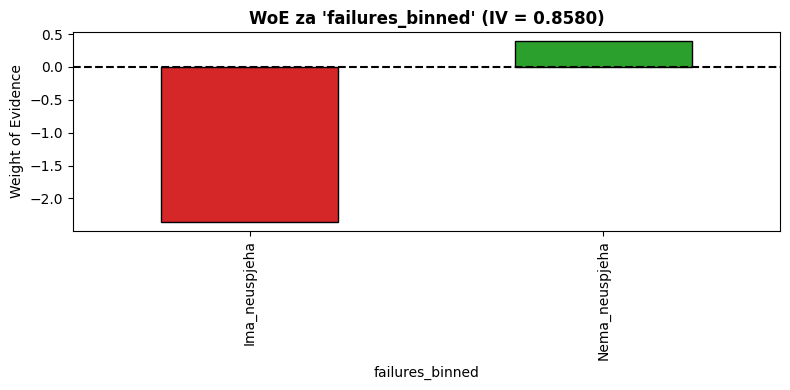

In [20]:
# Primjer binninga za varijablu 'failures' (prethodni neuspjesi)
# NAPOMENA: Ručni binning za 'failures' je već napravljen u Cell 4 kao 'failures_binned'
# jer automatski qcut ne radi dobro za varijable s većinom jedne vrijednosti

print("ANALIZA BINNINGA: VARIJABLA 'failures' (prethodni neuspjesi)")
print("="*80)

print("\n PROBLEM S AUTOMATSKIM BINNINGOM:")
print("   Varijabla 'failures' ima vrijednosti 0, 1, 2, 3")
print("   Većina učenika ima failures=0, pa qcut ne može stvoriti smislene binove")
print("   Zato smo u Cell 4 ručno kreirali 'failures_binned'\n")

# WoE tablica za biniranu verziju (već izračunata u glavnoj petlji)
print(" WoE TABLICA ZA 'failures_binned' (ručno binirana verzija):")
if 'failures_binned' in woe_tables:
    display(woe_tables['failures_binned'].round(4))
    binned_iv = iv_df[iv_df['Varijabla'] == 'failures_binned']['IV'].values[0]
else:
    # Ako nije u tablici, izračunaj
    woe_grouped, binned_iv = calculate_woe_iv(df, 'failures_binned', 'target_G1')
    display(woe_grouped.round(4))

print(f"\n REZULTAT RUČNOG BINNINGA:")
print(f"   'failures_binned' IV = {binned_iv:.4f}")
print(f"   Interpretacija: {get_iv_interpretation(binned_iv)}")
print("\n   Ručni binning je omogućio ispravnu procjenu prediktivne snage!")
print("   Bez binninga, automatski qcut bi dao IV ≈ 0 (lažno negativan rezultat)")

# Vizualizacija
if 'failures_binned' in woe_tables:
    plt.figure(figsize=(8, 4))
    woe_df = woe_tables['failures_binned']
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in woe_df['WoE'].values]
    woe_df['WoE'].plot(kind='bar', color=colors, edgecolor='black')
    plt.title(f"WoE za 'failures_binned' (IV = {binned_iv:.4f})", fontweight='bold')
    plt.ylabel('Weight of Evidence')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()


PRIMJER BINNINGA: VARIJABLA 'studytime' (vrijeme učenja)

 ORIGINALNA WoE TABLICA ZA 'studytime':
Primjer čitanja: “87% svih loših i 74% svih dobrih je u ovom binu”


,Dobri,Loši,%_Dobri,%_Loši,WoE,IV
studytime,,,,,,
"(0.999, 2.0]",297,220,0.7481,0.8730,-0.1544,0.0193
"(2.0, 3.0]",74,23,0.1864,0.0913,0.7141,0.0679
"(3.0, 4.0]",26,9,0.0655,0.0357,0.6064,0.0181



 ANALIZA ZA GRUPIRANJE:
   - studytime=1,2 (manje od 5h): Sličan negativan WoE → visoki rizik
   - studytime=3,4 (više od 5h): Sličan pozitivan WoE → niski rizik
   - Spajamo u dvije grupe: 'Malo_uci' i 'Puno_uci'

 NOVA WoE TABLICA ZA 'studytime_grouped':


,Dobri,Loši,%_Dobri,%_Loši,WoE,IV
studytime_grouped,,,,,,
Malo_uci,297,220,0.7481,0.873,-0.1544,0.0193
Puno_uci,100,32,0.2519,0.127,0.6849,0.0856



 USPOREDBA IV VRIJEDNOSTI:
   Originalni 'studytime':    IV = 0.1053
   Grupirani 'studytime':     IV = 0.1048


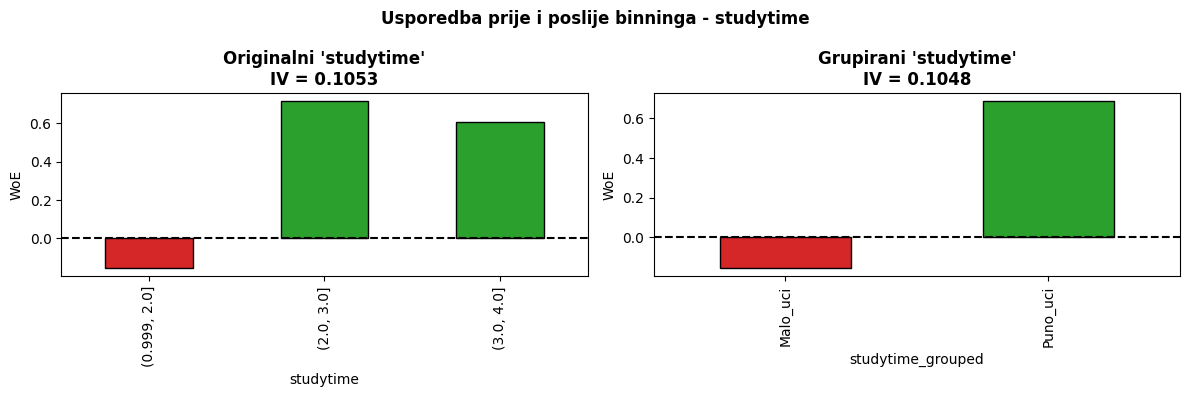

In [21]:
# Primjer binninga za varijablu 'studytime' (vrijeme učenja)
# Vrijednosti: 1=<2h, 2=2-5h, 3=5-10h, 4=>10h

print("PRIMJER BINNINGA: VARIJABLA 'studytime' (vrijeme učenja)")
print("="*80)

print("\n ORIGINALNA WoE TABLICA ZA 'studytime':")
print( "Primjer čitanja: “87% svih loših i 74% svih dobrih je u ovom binu”")
if 'studytime' in woe_tables:
    display(woe_tables['studytime'].round(4))

print("\n ANALIZA ZA GRUPIRANJE:")
print("   - studytime=1,2 (manje od 5h): Sličan negativan WoE → visoki rizik")
print("   - studytime=3,4 (više od 5h): Sličan pozitivan WoE → niski rizik")
print("   - Spajamo u dvije grupe: 'Malo_uci' i 'Puno_uci'")

# Kreiranje nove grupirane varijable
df['studytime_grouped'] = df['studytime'].apply(lambda x: 'Malo_uci' if x <= 2 else 'Puno_uci')

# Računanje WoE i IV za novu varijablu
woe_study_grouped, iv_study_grouped = calculate_woe_iv(df, 'studytime_grouped', 'target_G1')

print(f"\n NOVA WoE TABLICA ZA 'studytime_grouped':")
display(woe_study_grouped.round(4))

# Usporedba
original_iv_study = iv_df[iv_df['Varijabla'] == 'studytime']['IV'].values[0]
print(f"\n USPOREDBA IV VRIJEDNOSTI:")
print(f"   Originalni 'studytime':    IV = {original_iv_study:.4f}")
print(f"   Grupirani 'studytime':     IV = {iv_study_grouped:.4f}")

# Grafički prikaz usporedbe
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Originalni
if 'studytime' in woe_tables:
    colors = ['#d62728' if x < 0 else '#2ca02c' for x in woe_tables['studytime']['WoE'].values]
    woe_tables['studytime']['WoE'].plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
    axes[0].set_title(f"Originalni 'studytime'\nIV = {original_iv_study:.4f}", fontweight='bold')
    axes[0].axhline(y=0, color='black', linestyle='--')
    axes[0].set_ylabel('WoE')

# Grupirani
colors = ['#d62728' if x < 0 else '#2ca02c' for x in woe_study_grouped['WoE'].values]
woe_study_grouped['WoE'].plot(kind='bar', ax=axes[1], color=colors, edgecolor='black')
axes[1].set_title(f"Grupirani 'studytime'\nIV = {iv_study_grouped:.4f}", fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='--')
axes[1].set_ylabel('WoE')

plt.suptitle('Usporedba prije i poslije binninga - studytime', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()


---

## 5. Spoznaje o profilima i uzročno-posljedičnim vezama

**Što radimo:** Na temelju WoE/IV analize identificiramo rizične profile učenika i objašnjavamo uzročno-posljedične veze.

**Doprinos analizi:**
- Definira TKO su najugroženiji učenici na temelju podataka
- Objašnjava ZAŠTO se pad događa
- Povezuje statističke nalaze s logičkim objašnjenjima


In [22]:
print("ANALIZA RIZIČNIH PROFILA NA TEMELJU WoE/IV")

print("\n IDENTIFICIRANI RIZIČNI PROFILI:")
print("="*60)

risk_profiles = []

for idx, row in top_features.iterrows():
    feature = row['Varijabla']
    woe_df = woe_tables[feature]
    
    # Pronalaženje kategorije s najnegativnijim WoE
    min_woe_idx = woe_df['WoE'].idxmin()
    min_woe_val = woe_df.loc[min_woe_idx, 'WoE']
    
    risk_profiles.append({
        'Varijabla': feature,
        'Rizična_kategorija': str(min_woe_idx),
        'WoE': min_woe_val,
        'IV': row['IV']
    })
    
    print(f"\n {feature.upper()}:")
    print(f"   Najrizičnija kategorija: {min_woe_idx}")
    print(f"   WoE = {min_woe_val:.3f}")
    
    # Dodavanje kontekstualnog objašnjenja
    if feature == 'failures_binned':
        print("    Učenici s prethodnim neuspjesima imaju značajno veći rizik pada.")
        print("    Uzrok: Prethodni neuspjesi ukazuju na sistemske poteškoće u učenju.")
    elif feature == 'Medu':
        print("    Niže obrazovanje majke korelira s većim rizikom pada.")
        print("    Uzrok: Manje podrške i pomoći pri učenju kod kuće.")
    elif feature == 'higher':
        print("    Učenici bez aspiracija za višim obrazovanjem imaju veći rizik.")
        print("    Uzrok: Manjak motivacije i dugoročnih ciljeva.")
    elif feature == 'studytime':
        print("    Manje vremena za učenje = veći rizik pada.")
        print("    Uzrok: Nedovoljno uloženog truda i pripreme.")
    elif feature == 'Dalc' or feature == 'Walc':
        print("    Veća konzumacija alkohola = veći rizik pada.")
        print("    Uzrok: Alkohol utječe na koncentraciju i kognitivne sposobnosti.")
    elif feature == 'age':
        print("    Stariji učenici imaju veći rizik pada.")
        print("    Uzrok: Vjerojatno ponavljači ili učenici s poviješću problema.")

print("\n" + "="*60)
print(" SAŽETAK RIZIČNIH PROFILA")
print("="*60)
risk_df = pd.DataFrame(risk_profiles)
display(risk_df)


ANALIZA RIZIČNIH PROFILA NA TEMELJU WoE/IV

 IDENTIFICIRANI RIZIČNI PROFILI:

 FAILURES_BINNED:
   Najrizičnija kategorija: Ima_neuspjeha
   WoE = -2.355
    Učenici s prethodnim neuspjesima imaju značajno veći rizik pada.
    Uzrok: Prethodni neuspjesi ukazuju na sistemske poteškoće u učenju.

 HIGHER:
   Najrizičnija kategorija: no
   WoE = -2.229
    Učenici bez aspiracija za višim obrazovanjem imaju veći rizik.
    Uzrok: Manjak motivacije i dugoročnih ciljeva.

 SCHOOL:
   Najrizičnija kategorija: MS
   WoE = -0.849

 MEDU:
   Najrizičnija kategorija: (-0.001, 1.0]
   WoE = -0.684
    Niže obrazovanje majke korelira s većim rizikom pada.
    Uzrok: Manje podrške i pomoći pri učenju kod kuće.

 DALC:
   Najrizičnija kategorija: (2.0, 5.0]
   WoE = -1.187
    Veća konzumacija alkohola = veći rizik pada.
    Uzrok: Alkohol utječe na koncentraciju i kognitivne sposobnosti.

 SAŽETAK RIZIČNIH PROFILA


,Varijabla,Rizična_kategorija,WoE,IV
0,failures_binned,Ima_neuspjeha,-2.355466,0.8580
1,higher,no,-2.229460,0.5162
2,school,MS,-0.848922,0.4156
3,Medu,"(-0.001, 1.0]",-0.683693,0.2643
4,Dalc,"(2.0, 5.0]",-1.186875,0.1940


KOMPOZITNI RIZIČNI PROFIL - NAJUGROŽENIJI UČENICI

 DISTRIBUCIJA UČENIKA PO RAZINI RIZIKA:
--------------------------------------------------
   Rizik score = 0 ( Nizak): 59 učenika, stopa pada = 13.6%
   Rizik score = 1 ( Nizak): 222 učenika, stopa pada = 23.0%
   Rizik score = 2 ( Srednji): 244 učenika, stopa pada = 39.8%
   Rizik score = 3 ( Visok): 103 učenika, stopa pada = 76.7%
   Rizik score = 4 ( Visok): 21 učenika, stopa pada = 81.0%


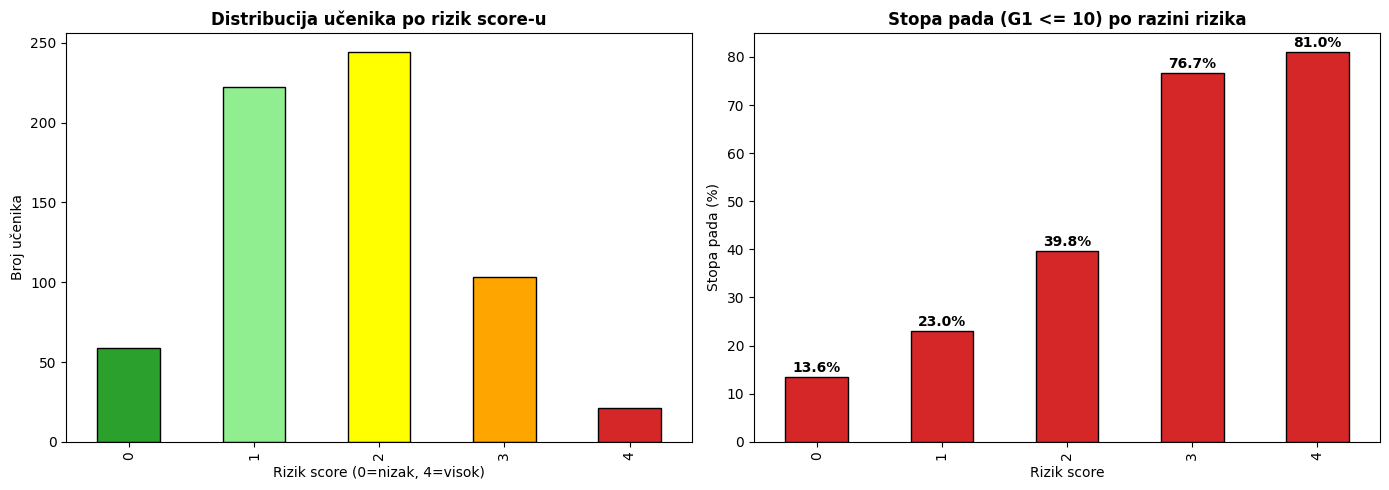


 STATISTIČKA VALIDACIJA:
--------------------------------------------------
   Stopa pada - nizak rizik (score 0-1):  21.0%
   Stopa pada - visok rizik (score 3-4):  77.4%
   Razlika:                               56.4 postotnih bodova


In [23]:
print("KOMPOZITNI RIZIČNI PROFIL - NAJUGROŽENIJI UČENICI")
print("="*80)

# Definiranje rizičnih uvjeta na temelju WoE analize
df['rizik_failures'] = (df['failures'] > 0).astype(int)
df['rizik_studytime'] = (df['studytime'] <= 2).astype(int)
df['rizik_Medu'] = (df['Medu'] <= 2).astype(int)  # Niže obrazovanje
df['rizik_alkohol'] = ((df['Dalc'] >= 3) | (df['Walc'] >= 4)).astype(int)

# Ukupni rizik score
df['rizik_score'] = (df['rizik_failures'] + df['rizik_studytime'] + 
                     df['rizik_Medu'] + df['rizik_alkohol'])

# Analiza po razini rizika
print("\n DISTRIBUCIJA UČENIKA PO RAZINI RIZIKA:")
print("-"*50)
for score in sorted(df['rizik_score'].unique()):
    n_students = (df['rizik_score'] == score).sum()
    n_failed = ((df['rizik_score'] == score) & (df['target_G1'] == 1)).sum()
    fail_rate = n_failed / n_students * 100 if n_students > 0 else 0
    
    risk_level = " Nizak" if score <= 1 else (" Srednji" if score == 2 else " Visok")
    print(f"   Rizik score = {score} ({risk_level}): {n_students} učenika, stopa pada = {fail_rate:.1f}%")

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graf 1: Distribucija rizik scorea
risk_counts = df['rizik_score'].value_counts().sort_index()
colors = ['#2ca02c', '#90EE90', '#FFFF00', '#FFA500', '#d62728'][:len(risk_counts)]
risk_counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black')
axes[0].set_title('Distribucija učenika po rizik score-u', fontweight='bold')
axes[0].set_xlabel('Rizik score (0=nizak, 4=visok)')
axes[0].set_ylabel('Broj učenika')

# Graf 2: Stopa pada po rizik scoreu
fail_rates = df.groupby('rizik_score')['target_G1'].mean() * 100
fail_rates.plot(kind='bar', ax=axes[1], color='#d62728', edgecolor='black')
axes[1].set_title('Stopa pada (G1 <= 10) po razini rizika', fontweight='bold')
axes[1].set_xlabel('Rizik score')
axes[1].set_ylabel('Stopa pada (%)')

for i, v in enumerate(fail_rates.values):
    axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistički značaj
print("\n STATISTIČKA VALIDACIJA:")
print("-"*50)
low_risk = df[df['rizik_score'] <= 1]['target_G1'].mean() * 100
high_risk = df[df['rizik_score'] >= 3]['target_G1'].mean() * 100
print(f"   Stopa pada - nizak rizik (score 0-1):  {low_risk:.1f}%")
print(f"   Stopa pada - visok rizik (score 3-4):  {high_risk:.1f}%")
print(f"   Razlika:                               {high_risk - low_risk:.1f} postotnih bodova")


---

## 6. Prijedlog rješenja problema

**Što radimo:** Na temelju IV/WoE analize predlažemo konkretne korake intervencije usmjerene na identificirane rizične profile.

**Metodologija:**
1. Određujemo gdje je uzrok problema (varijable s najvišim IV)
2. Predlažemo ciljane intervencije za svaki rizični faktor
3. Kreiramo strategiju usmjerenu na najrizičnije profile

**Doprinos analizi:**
- Strategija intervencije temeljena na dokazima (evidence-based strategy)
- Optimalna alokacija resursa na najugroženije skupine
- Mjerljivi ciljevi za smanjenje stope pada


In [24]:
print("\n PRIORITETNA LISTA VARIJABLI ZA INTERVENCIJU:")
print("-"*60)

interventions = {
    'failures_binned': {
        'problem': 'Prethodni školski neuspjesi',
        'rizik': 'Učenici s >=1 neuspjehom imaju drastično veći rizik pada',
        'intervencija': [
            '- Obvezna dodatna nastava za učenike s poviješću neuspjeha',
            '- Personalizirani plan učenja s redovitim praćenjem',
            '- Mentorski program s uspješnijim učenicima'
        ]
    },
    'Medu': {
        'problem': 'Niže obrazovanje majke',
        'rizik': 'Učenici čije majke imaju niže obrazovanje imaju manje podrške',
        'intervencija': [
            '- Program pomoći pri učenju u školi',
            '- Edukacija roditelja o načinima podrške učenju',
            '- Osiguravanje pristupa obrazovnim resursima'
        ]
    },
    'studytime': {
        'problem': 'Nedovoljno vremena za učenje',
        'rizik': 'Učenici koji uče manje od 5h tjedno imaju veći rizik',
        'intervencija': [
            '- Radionice o tehnikama učenja i time managementu',
            '- Obvezne studijske grupe za rizične učenike',
            '- Praćenje i poticanje redovitog učenja'
        ]
    },
    'Dalc': {
        'problem': 'Konzumacija alkohola radnim danom',
        'rizik': 'Učenici koji konzumiraju alkohol imaju lošije ocjene',
        'intervencija': [
            '- Preventivni programi o štetnosti alkohola',
            '- Suradnja s roditeljima i savjetodavnim službama',
            '- Identificiranje i praćenje rizičnih učenika'
        ]
    },
    'higher': {
        'problem': 'Nedostatak aspiracija za višim obrazovanjem',
        'rizik': 'Učenici bez motivacije za nastavak školovanja',
        'intervencija': [
            '- Karijerno savjetovanje i informiranje o mogućnostima',
            '- Posjeti sveučilištima i susreti s uspješnim alumnijima',
            '- Motivacijske radionice i postavljanje ciljeva'
        ]
    }
}

for i, (var, info) in enumerate(interventions.items(), 1):
    iv_val = iv_df[iv_df['Varijabla'] == var]['IV'].values
    iv_str = f"(IV = {iv_val[0]:.4f})" if len(iv_val) > 0 else ""
    
    print(f"\n{'─'*60}")
    print(f" PRIORITET {i}: {var.upper()} {iv_str}")
    print(f"{'─'*60}")
    print(f"   Problem: {info['problem']}")
    print(f"   Rizik: {info['rizik']}")
    print(f"\n    PREPORUČENE INTERVENCIJE:")
    for intervention in info['intervencija']:
        print(f"      {intervention}")



 PRIORITETNA LISTA VARIJABLI ZA INTERVENCIJU:
------------------------------------------------------------

────────────────────────────────────────────────────────────
 PRIORITET 1: FAILURES_BINNED (IV = 0.8580)
────────────────────────────────────────────────────────────
   Problem: Prethodni školski neuspjesi
   Rizik: Učenici s >=1 neuspjehom imaju drastično veći rizik pada

    PREPORUČENE INTERVENCIJE:
      - Obvezna dodatna nastava za učenike s poviješću neuspjeha
      - Personalizirani plan učenja s redovitim praćenjem
      - Mentorski program s uspješnijim učenicima

────────────────────────────────────────────────────────────
 PRIORITET 2: MEDU (IV = 0.2643)
────────────────────────────────────────────────────────────
   Problem: Niže obrazovanje majke
   Rizik: Učenici čije majke imaju niže obrazovanje imaju manje podrške

    PREPORUČENE INTERVENCIJE:
      - Program pomoći pri učenju u školi
      - Edukacija roditelja o načinima podrške učenju
      - Osiguravanje pri

In [25]:
print("IDENTIFIKACIJA CILJNE SKUPINE ZA INTERVENCIJU")
print("="*80)

# Definiranje visokorizičnih učenika (rizik score >= 2)
high_risk_students = df[df['rizik_score'] >= 2]
total_students = len(df)
n_high_risk = len(high_risk_students)

print(f"\n STATISTIKA CILJNE SKUPINE:")
print("-"*50)
print(f"   Ukupan broj učenika:           {total_students}")
print(f"   Broj visokorizičnih učenika:   {n_high_risk} ({n_high_risk/total_students*100:.1f}%)")
print(f"   Broj učenika s padom (G1<=10): {df['target_G1'].sum()}")

# Koliko bi bilo učinkovito ciljati visokorizične?
high_risk_failures = high_risk_students['target_G1'].sum()
all_failures = df['target_G1'].sum()
print(f"\n POTENCIJALNI UČINAK INTERVENCIJE:")
print("-"*50)
print(f"   Od svih učenika s padom, {high_risk_failures/all_failures*100:.1f}% je u visokorizičnoj skupini")
print(f"   → Ciljanjem {n_high_risk/total_students*100:.1f}% učenika možemo dohvatiti {high_risk_failures/all_failures*100:.1f}% padova!")


IDENTIFIKACIJA CILJNE SKUPINE ZA INTERVENCIJU

 STATISTIKA CILJNE SKUPINE:
--------------------------------------------------
   Ukupan broj učenika:           649
   Broj visokorizičnih učenika:   368 (56.7%)
   Broj učenika s padom (G1<=10): 252

 POTENCIJALNI UČINAK INTERVENCIJE:
--------------------------------------------------
   Od svih učenika s padom, 76.6% je u visokorizičnoj skupini
   → Ciljanjem 56.7% učenika možemo dohvatiti 76.6% padova!


---

## 7. Zaključak i sažetak analize

### Sažetak metodologije WoE/IV

**Weight of Evidence (WoE)** i **Information Value (IV)** statističke su tehnike za:
- Kvantifikaciju prediktivne snage varijabli
- Identificiranje rizičnih kategorija unutar svake varijable
- Odabir varijabli za prediktivno modeliranje

### Ključni nalazi ove analize

| Rang | Varijabla | Snaga prediktora | Interpretacija |
|------|-----------|------------------|----------------|
| 1 | failures_binned | Vrlo jak utjecaj | Prethodni neuspjesi su NAJJAČI prediktor pada (IV ≈ 0.86) |
| 2 | higher | Jak utjecaj | Aspiracije za višim obrazovanjem su zaštitni faktor |
| 3 | school | Jak utjecaj | Tip škole značajno utječe na uspjeh |
| 4 | Medu | Jak utjecaj | Obrazovanje majke značajno utječe na uspjeh |
| 5 | Dalc | Jak utjecaj | Konzumacija alkohola povećava rizik pada |

**Napomena:** Varijabla `failures` zahtijeva ručni binning jer automatski `qcut` ne radi ispravno za varijable s većinom jedne vrijednosti (većina učenika ima 0 neuspjeha).

**Napomena:** Prema korištenoj skali:
- IV < 0.02 → Vrlo slab utjecaj
- IV 0.02–0.1 → Slab utjecaj  
- IV 0.1–1.0 → Jak utjecaj
- IV > 1.0 → Vrlo jak utjecaj

### Preporuke za praksu

1. **Rana identifikacija** - Koristiti WoE/IV model za identifikaciju rizičnih učenika na početku školske godine
2. **Ciljana intervencija** - Usmjeriti resurse na učenike s visokim rizik score-om
3. **Praćenje učinkovitosti** - Mjeriti smanjenje stope pada nakon implementacije intervencija

### Ograničenja analize

- WoE/IV metodologija pretpostavlja linearni odnos između prediktora i cilja
- Korelacija ne implicira kauzalnost - potrebna su dodatna istraživanja
- Model je specifičan za ovaj dataset i može zahtijevati rekalibraciju za druge populacije


VIZUALNI SAŽETAK - RANGIRANJE VARIJABLI PO PREDIKTIVNOJ SNAZI (IV)


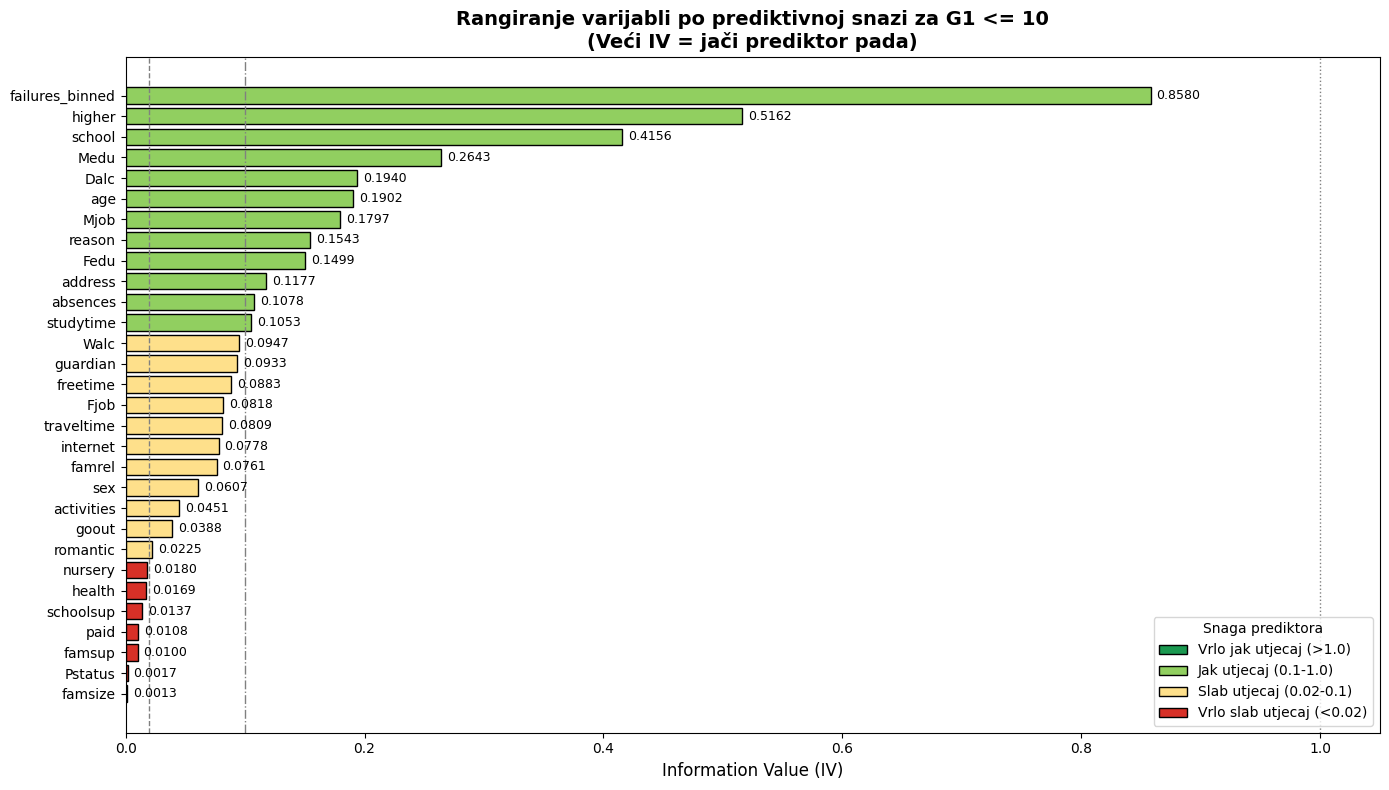

In [26]:
print("VIZUALNI SAŽETAK - RANGIRANJE VARIJABLI PO PREDIKTIVNOJ SNAZI (IV)")
print("="*80)

# Grafički prikaz svih IV vrijednosti
fig, ax = plt.subplots(figsize=(14, 8))

# Boje prema razini prediktivnosti 
colors = []
for iv in iv_df['IV']:
    if iv > 1.0:
        colors.append('#1a9850')  # Vrlo jak utjecaj - tamno zelena
    elif iv >= 0.1:
        colors.append('#91cf60')  # Jak utjecaj - zelena
    elif iv >= 0.02:
        colors.append('#fee08b')  # Slab utjecaj - žuta
    else:
        colors.append('#d73027')  # Vrlo slab utjecaj - crvena

# Horizontalni bar chart
bars = ax.barh(iv_df['Varijabla'], iv_df['IV'], color=colors, edgecolor='black')
ax.set_xlabel('Information Value (IV)', fontsize=12)
ax.set_title('Rangiranje varijabli po prediktivnoj snazi za G1 <= 10\n(Veći IV = jači prediktor pada)', 
             fontsize=14, fontweight='bold')

# Dodavanje vertikalne linije za pragove
ax.axvline(x=0.02, color='gray', linestyle='--', linewidth=1, label='Prag: Slab (0.02)')
ax.axvline(x=0.1, color='gray', linestyle='-.', linewidth=1, label='Prag: Jak (0.1)')
ax.axvline(x=1.0, color='gray', linestyle=':', linewidth=1, label='Prag: Vrlo jak (1.0)')

# Dodaj vrijednosti na stupce
for bar, iv in zip(bars, iv_df['IV']):
    ax.text(iv + 0.005, bar.get_y() + bar.get_height()/2, 
            f'{iv:.4f}', va='center', fontsize=9)

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1a9850', edgecolor='black', label='Vrlo jak utjecaj (>1.0)'),
    Patch(facecolor='#91cf60', edgecolor='black', label='Jak utjecaj (0.1-1.0)'),
    Patch(facecolor='#fee08b', edgecolor='black', label='Slab utjecaj (0.02-0.1)'),
    Patch(facecolor='#d73027', edgecolor='black', label='Vrlo slab utjecaj (<0.02)')
]
ax.legend(handles=legend_elements, loc='lower right', title='Snaga prediktora')

ax.invert_yaxis()  # Najveći IV na vrhu
plt.tight_layout()
plt.show()
